# Introduction and Setup
This section sets up the problem, including loading the data and initializing the discretized model.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from ExternalFunctions import nice_string_output, add_text_to_ax

In [12]:
data = np.loadtxt('dataM.txt')

x_obs = data[:, 0]
d_obs = np.array([data[:, 1]])

In [13]:
######### Initialization ###########
w_mean = 4
w_initial = []
total_width = 100

while True:
    w_initial.append(int(np.random.exponential(w_mean))+0.5)
    if np.sum(w_initial) >= total_width:
        w_initial = np.delete(w_initial, -1)                                #Delete so that the sum does not exceed 100cm.
        break
w_initial = np.insert(w_initial, 0, total_width - np.sum(w_initial))        #Insert one last value equal to the difference of the total width minus the sum 
                                                                            #, so that the new sum will be 100cm.
N_stripes = len(w_initial)                                                  #The number of stripes will be equal to the number of the widths.

m_initial = np.random.uniform(-4, 4, N_stripes)                             #Initial random magnetization vector.

N_points = 201
boundaries_initial = [False] * (N_points - 1)     #left boundary of each stripe

for i in range(len(w_initial)):
    j = int(np.sum(w_initial[:i])/0.5)
    boundaries_initial[j] = True

extended_boundaries_initial = boundaries_initial.copy()
extended_boundaries_initial.append(True)

p = boundaries_initial.count(True) / 201
print('Probability that a boundary exists at a random point:', np.round(p, 3))

Probability that a boundary exists at a random point: 0.164


# Constructing the G Matrix

In [14]:
#####Constructing G#####
constant = 200.                                 #This is m_0/2*pi in our system working with cm and nT.
h = 2.                                          #height of measurement
x_obs = data[:, 0]                              #grid of our data
x_points = np.linspace(-50, 50, 201)            #our grid
G = np.zeros((len(x_obs), len(x_points) - 1))   #Constructing the G matrix
for i in range(len(x_obs)):
    for j in range(len(x_points) - 1):
        distance = (x_obs[i] - x_points[j])**2
        num = distance - h**2
        denom = (distance + h**2)**2
        G[i, j] = - constant * (num / denom)

sigmas = [25**2]*len(x_obs)
covariance_inv = np.linalg.inv(np.diag(sigmas))

In [15]:
##Reducing m##
def reduce_m(m_r, w_r):
    m_reduced = []
    for i in range(len(w_r)):
        m_reduced.extend([m_r[int(2*np.sum(w_r[:i]))]])
    return m_reduced

##Extending m##
def extend_m(m_e, w_e):
    m_extended = []
    for i in range(len(w_e)):
        m_extended.extend([m_e[i]]*(int(2*np.sum(w_e[i]))))
    return m_extended

# Prior Sampling: Perturbation Function
This section defines `new_model()`, which samples from the prior distribution by applying different perturbations to the model (to be called iteratively).

In [16]:
def new_model(m_new, w_new, N_points, boundaries_new, extended_boundaries_new, i):
    
    mm = m_new.copy()
    ww = w_new.copy()
    m_new = reduce_m(mm, ww)

    perturbation_type = np.random.choice(['stripe_magnetization', 'boundary_perturbation'])

    if perturbation_type == 'stripe_magnetization':
        stripe_ID = np.random.randint(1, len(w_new))
        m_new[stripe_ID - 1] = np.random.normal(0, 2.5)
    else:   
        point_index = np.random.randint(1, N_points - 1)                   #Leaving out the boundaries of the plate
        add_boundary = np.random.choice([True, False], p=[0.125, 0.875])
        if add_boundary:  
            # Add a boundary
            if boundaries_new[point_index] == True:
                if i == 0:
                    pass
                else:
                    i -= 1
            else:
                stripe_ID = boundaries_new[:point_index].count(True)
                index_i = [i for i, v in enumerate(boundaries_new) if v == True][stripe_ID - 1]
                index_f = [i for i, v in enumerate(extended_boundaries_new) if v == True][stripe_ID]
                w_i = (point_index - index_i) * 0.5 
                w_f = (index_f - point_index) * 0.5              
                w_new[stripe_ID - 1] = w_i
                w_new = np.insert(w_new, stripe_ID, w_f)
                m_new[stripe_ID - 1] = np.random.normal(0, 2.5)
                m_new = np.insert(m_new, stripe_ID, np.random.normal(0, 2.5))
                boundaries_new[point_index] = True                         #set a new boundary at that point
                extended_boundaries_new[point_index] = True                #set a new boundary at that point

        else:
            if boundaries_new[point_index] == False:
                if i == 0:
                    pass
                else:
                    i -= 1
            else:
                stripe_ID = boundaries_new[:point_index].count(True) 
                index_i = [i for i, v in enumerate(boundaries_new) if v == True][stripe_ID - 1]
                index_f = [i for i, v in enumerate(extended_boundaries_new) if v == True][stripe_ID + 1]           
                w_f = (index_f - index_i) * 0.5
                w_new[stripe_ID - 1] = w_f
                w_new = np.delete(w_new, stripe_ID)
                m_new[stripe_ID - 1] = np.random.normal(0, 2.5)
                m_new = np.delete(m_new, stripe_ID)
                boundaries_new[point_index] = False                        #set a new boundary at that point
                extended_boundaries_new[point_index] = False               #set a new boundary at that point
    mmm = extend_m(m_new, w_new)
    return mmm, w_new, boundaries_new, extended_boundaries_new

# Likelihood Function
The `log_Likelihood()` function computes the log of the likelihood given the observed data and a candidate model. This determines if the new model is accepted or not.

In [17]:
def log_Likelihood(m_all, data, G, covariance_inv):
    m_all = np.array([m_all])
    diff = data.T - G @ m_all.T
    exponent = -0.5*diff.T @ (covariance_inv @ diff)
    return exponent

# Simulation and Visualization

  0%|          | 0/100000 [00:00<?, ?it/s]C:\Users\George\AppData\Local\Temp\ipykernel_9380\1703320450.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_accept = min(1, float(ratio))
100%|██████████| 100000/100000 [00:32<00:00, 3124.09it/s]


(200, 60881)


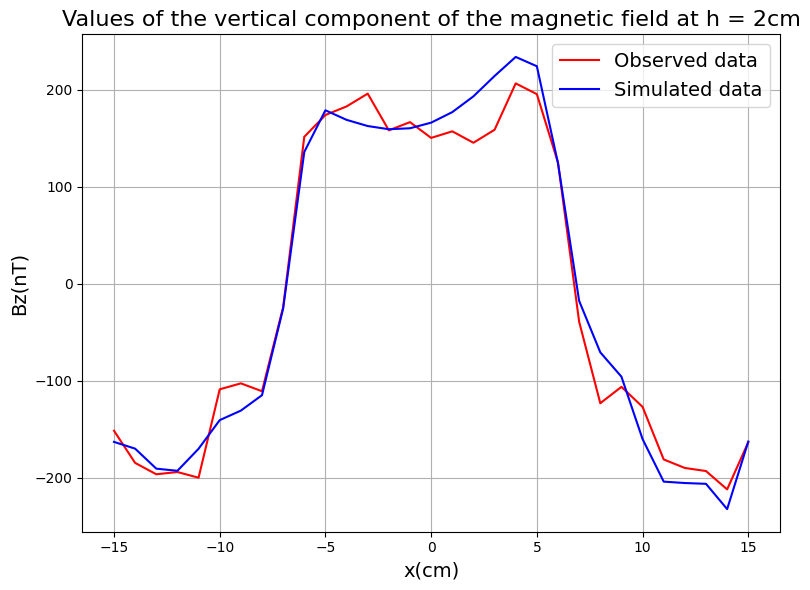

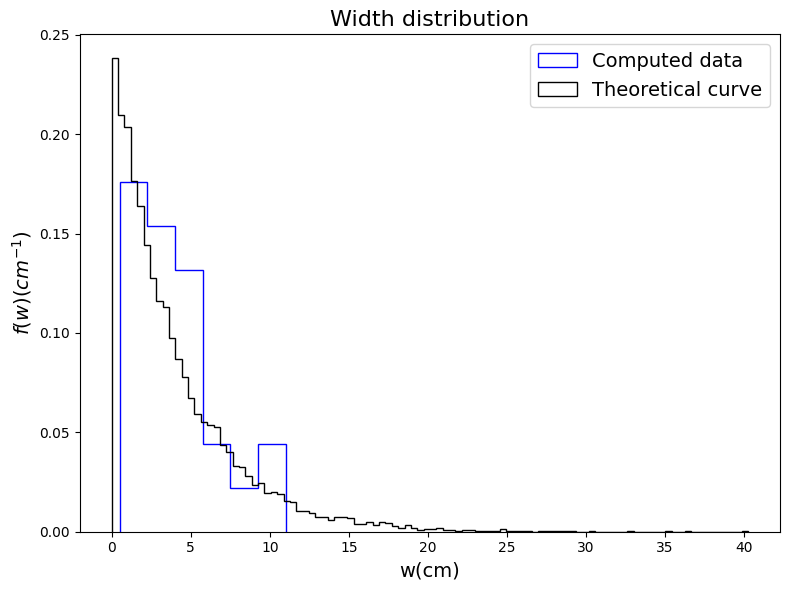

In [18]:
m_initial = extend_m(m_initial, w_initial)

def Simulation(m, w, N_points, boundaries, extended_boundaries, d_obs, G, covariance_inv):

    N_t = 100_000
    model_samples = []

    for i in tqdm(range(N_t)):
        current_m, current_w, current_boundaries, current_ext_boundaries = m, w, boundaries, extended_boundaries
        proposed_m, proposed_w, proposed_boundaries, proposed_ext_boundaries = new_model(current_m.copy(), current_w.copy(), N_points, current_boundaries.copy(), current_ext_boundaries.copy(), i)
    
        logL_old = log_Likelihood(current_m.copy(), d_obs, G, covariance_inv)
        logL_new = log_Likelihood(proposed_m.copy(), d_obs, G, covariance_inv)
        
        ratio = np.exp(logL_new - logL_old)
        p_accept = min(1, float(ratio))

        Criterion = np.random.choice([True, False], p=[p_accept, 1. - p_accept])
        if Criterion:
            m, w, boundaries, extended_boundaries = proposed_m, proposed_w, proposed_boundaries, proposed_ext_boundaries
            model_samples.extend(m)
        else:
            m, w, boundaries, extended_boundaries = current_m, current_w, current_boundaries, current_ext_boundaries

    proposed_m = np.array([proposed_m])
    model_samples = np.array([model_samples])
    return proposed_m.T, proposed_w, model_samples.reshape(len(m), -1)

m, w, samples = Simulation(m_initial, w_initial, N_points, boundaries_initial, extended_boundaries_initial, d_obs, G, covariance_inv)
d = G@m
print(samples.shape)
m_initial = np.array([m_initial])
m_initial = m_initial.T

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(x_obs, d_obs.T, 'r', label = 'Observed data')
ax.plot(x_obs, d, 'b', label = 'Simulated data')
ax.legend(fontsize = 14)
ax.set_xlabel("x(cm)", fontsize = 14)
ax.set_ylabel("Bz(nT)", fontsize = 14)
ax.set_title("Values of the vertical component of the magnetic field at h = 2cm", fontsize = 16)

plt.grid()
fig.tight_layout()

plt.show()

fig, ax = plt.subplots(figsize = (8,6))

ax.hist(w, bins = 6, histtype = 'step', label = 'Computed data', density = True, color = 'b')
ax.hist(np.random.exponential(4, size = 10000), bins = 100, label = 'Theoretical curve', density = True, histtype = 'step', color = 'k')
ax.legend(fontsize = 14)
ax.set_xlabel("w(cm)", fontsize = 14)
ax.set_ylabel("$f(w) (cm^{-1})$", fontsize = 14)
ax.set_title("Width distribution", fontsize = 16)

fig.tight_layout()

plt.show()

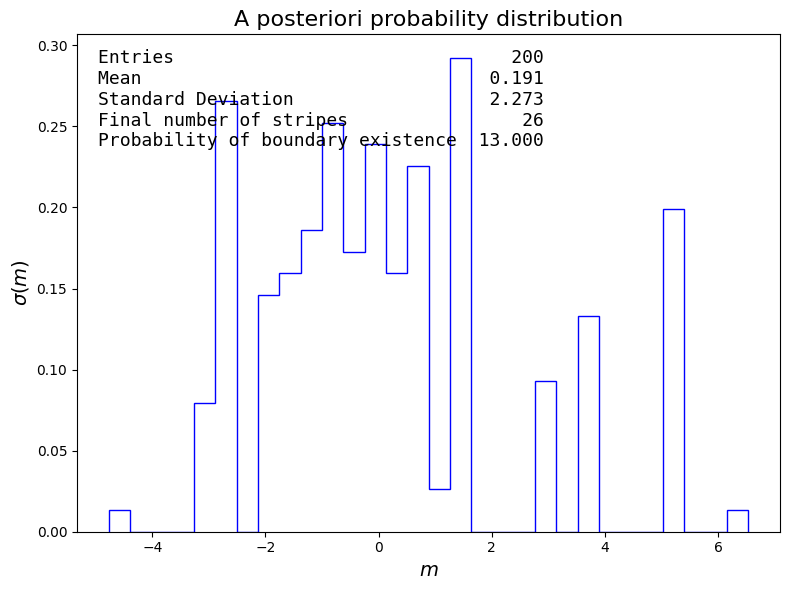

In [19]:
fig, ax = plt.subplots(figsize = (8,6))

plt.hist(m, bins = 30, histtype = 'step', density = True, color = 'b')
ax.set_xlabel('$m$', fontsize = 14)
ax.set_ylabel('$σ(m)$', fontsize = 14)
ax.set_title('A posteriori probability distribution', fontsize = 16)
d = {'Entries' : len(m),
     'Mean': np.mean(m),
     'Standard Deviation':  np.std(m),
     'Final number of stripes': len(w),
     'Probability of boundary existence': np.round(len(w)/(N_points - 1)*100, 3) }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.03, 0.97, text, ax, fontsize=13)

fig.tight_layout()
plt.show()

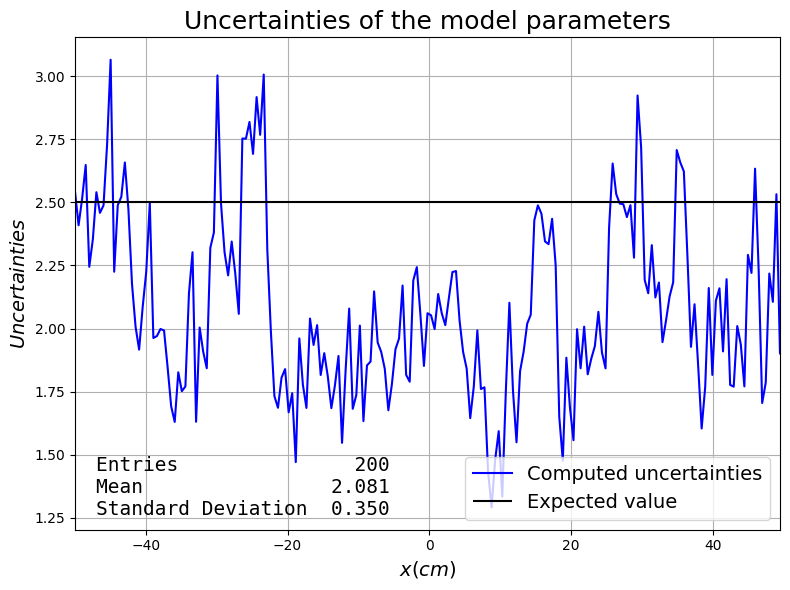

In [20]:
cov = np.cov(samples)
std = np.sqrt(np.diag(cov))

x_all = np.linspace(-50, 50, N_points - 1)
fig, ax = plt.subplots(figsize = (8,6))

plt.plot(x_all, std, 'b', label = 'Computed uncertainties')
ax.hlines(2.5, xmin = -50, xmax = 49.5, color = 'k', label = 'Expected value')
ax.set_xlabel('$x(cm)$', fontsize = 14)
ax.set_ylabel('$Uncertainties$', fontsize = 14)
ax.set_xlim([- 50,  49.5])
ax.set_title('Uncertainties of the model parameters', fontsize = 18)
ax.legend(fontsize = 14, loc = 'lower right')
d = {'Entries' : len(x_all),
     'Mean': np.mean(std),
     'Standard Deviation':  np.std(std)}

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.03, 0.15, text, ax, fontsize=14)

fig.tight_layout()
plt.grid()
plt.show()